Epoch [100/1000], Loss: 0.870341
Epoch [200/1000], Loss: 0.107981
Epoch [300/1000], Loss: 0.047370
Epoch [400/1000], Loss: 0.027385
Epoch [500/1000], Loss: 0.018984
Epoch [600/1000], Loss: 0.012274
Epoch [700/1000], Loss: 0.007140
Epoch [800/1000], Loss: 0.004173
Epoch [900/1000], Loss: 0.004129
Epoch [1000/1000], Loss: 0.003542


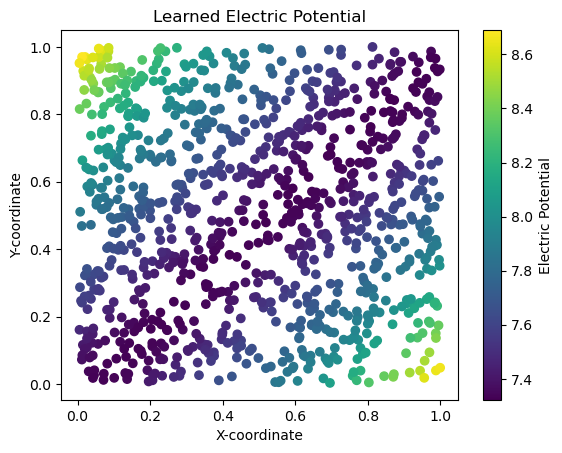

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# Define the neural field network
class NeuralField(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralField, self).__init__()
        self.layer = nn.Linear(input_size, hidden_size)

    def forward(self, x):
        return torch.relu(self.layer(x))

# Define the Laplace's equation loss function
def laplace_loss(predictions, positions, conductivity):
    # Calculate second derivatives using finite differences
    d2V_dx2 = torch.autograd.grad(predictions, positions, grad_outputs=torch.ones_like(predictions), create_graph=True)[0][:, 0]
    d2V_dy2 = torch.autograd.grad(predictions, positions, grad_outputs=torch.ones_like(predictions), create_graph=True)[0][:, 1]
    
    # Laplace's equation
    laplace_loss = (conductivity * d2V_dx2 + conductivity * d2V_dy2).pow(2).mean()
    
    return laplace_loss

# Generate synthetic data (positions in 2D)
np.random.seed(42)
positions = torch.tensor(np.random.rand(1000, 2), dtype=torch.float32, requires_grad=True)

# Set the conductivity for the homogeneous isotropic medium
conductivity = torch.tensor(1.0, dtype=torch.float32)

# Create the neural field model
input_size = 2  # x, y coordinates
hidden_size = 64
model = NeuralField(input_size, hidden_size)

# Set up optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    # Forward pass
    predictions = model(positions)
    
    # Calculate Laplace's equation loss
    loss = laplace_loss(predictions, positions, conductivity)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.6f}')

# Plot the learned electric potential
with torch.no_grad():
    learned_potential = model(positions).detach().numpy()

plt.scatter(positions[:, 0].detach().numpy(), positions[:, 1].detach().numpy(), c=learned_potential.sum(axis=1), cmap='viridis')
plt.title('Learned Electric Potential')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.colorbar(label='Electric Potential')
plt.show()


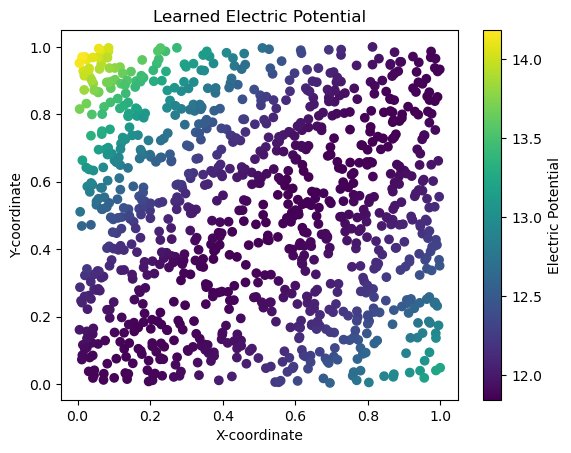

In [8]:
plt.scatter(positions[:, 0].detach().numpy(), positions[:, 1].detach().numpy(), c=learned_potential.sum(axis=1), cmap='viridis')
plt.title('Learned Electric Potential')
plt.xlabel('X-coordinate')
plt.ylabel('Y-coordinate')
plt.colorbar(label='Electric Potential')
plt.show()


In [4]:
learned_potential.shape

(1000, 64)

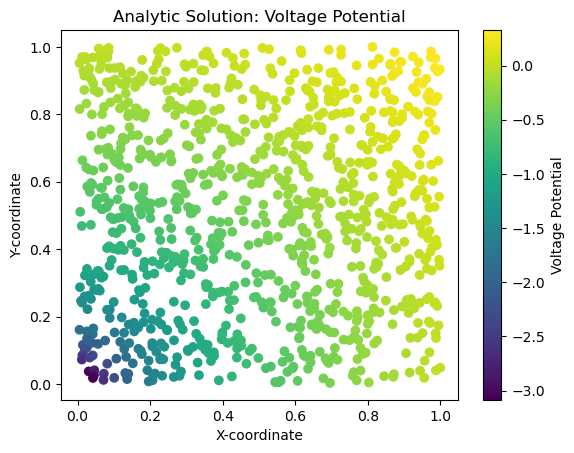

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def gaussian_splatting(images, camera_parameters):
    # Initialize the 3D space
    space_dim = camera_parameters['space_dim']
    space = np.zeros(space_dim)

    # Loop through each image
    for img, img_params in zip(images, camera_parameters['image_params']):
        # Unpack image parameters
        img_dim = img_params['image_dim']
        img_pos = img_params['position']
        img_color = img_params['color']

        # Loop through each pixel in the image
        for x in range(img_dim[0]):
            for y in range(img_dim[1]):
                # Calculate the 3D position of the pixel based on camera parameters
                pixel_pos = np.array([x, y, 1])
                world_pos = np.dot(np.linalg.inv(img), pixel_pos)
                world_pos = world_pos / world_pos[2]  # Normalize by z coordinate

                # Check if the pixel position is within the 3D space
                if (0 <= world_pos[0] < space_dim[0]) and (0 <= world_pos[1] < space_dim[1]) and (0 <= world_pos[2] < space_dim[2]):
                    # Calculate Gaussian kernel weights based on distance
                    dist = np.linalg.norm(world_pos - img_pos)
                    weight = np.exp(-0.5 * (dist / img_params['sigma']) ** 2)

                    # Blend pixel color into the 3D space using Gaussian weights
                    space[int(world_pos[0]), int(world_pos[1]), int(world_pos[2])] += weight * img_color

    return space

# Example input images (grayscale, for simplicity)
image1 = np.random.rand(100, 100)
image2 = np.random.rand(100, 100)
image3 = np.random.rand(100, 100)

# Example camera parameters
camera_parameters = {
    'space_dim': (200, 200, 200),  # 3D space dimensions
    'image_params': [
        {'image_dim': (100, 100), 'position': (50, 50, 50), 'color': 1, 'sigma': 5},  # Example camera 1
        {'image_dim': (100, 100), 'position': (100, 100, 100), 'color': 0.5, 'sigma': 10},  # Example camera 2
        {'image_dim': (100, 100), 'position': (150, 150, 150), 'color': 0.75, 'sigma': 8}  # Example camera 3
    ]
}

# Perform Gaussian splatting
result_space = gaussian_splatting([image1, image2, image3], camera_parameters)

# Visualize the result
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.voxels(result_space, edgecolor='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


ValueError: shapes (100,100) and (3,) not aligned: 100 (dim 1) != 3 (dim 0)

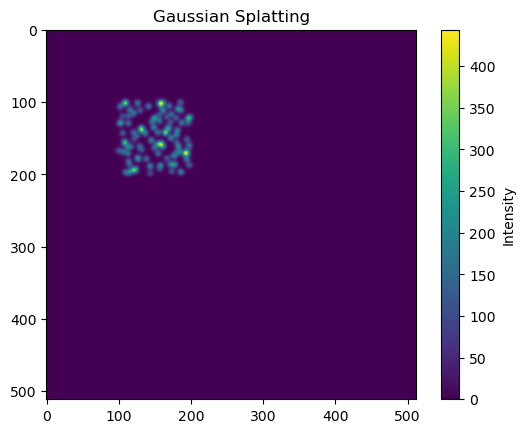

In [16]:
import numpy as np
import matplotlib.pyplot as plt

def gaussian_splatting(points, image_shape, sigma=1.0):
    """
    Perform Gaussian splatting for the given points onto an image grid.

    Parameters:
    points : numpy.ndarray
        Array of shape (N, 3) representing 3D points (x, y, z) to be splatted.
    image_shape : tuple
        Tuple representing the shape (height, width) of the output image.
    sigma : float, optional
        Standard deviation of the Gaussian function, controls the spread of splatted points.

    Returns:
    numpy.ndarray
        An image with the splatted points.
    """
    height, width = image_shape
    image = np.zeros(image_shape)

    # Define a grid of coordinates
    x = np.arange(width)
    y = np.arange(height)
    X, Y = np.meshgrid(x, y, indexing='xy')

    for point in points:
        # Calculate the Gaussian kernel
        dx = X - point[0]
        dy = Y - point[1]
        d_squared = dx**2 + dy**2
        kernel = np.exp(-0.5 * d_squared / sigma**2)

        # Update the image by adding the Gaussian kernel
        image += kernel * point[2]  # Z-coordinate of the point

    return image

# Example usage:
# Generate some random 3D points
np.random.seed(0)
num_points = 100
points = 100 + np.random.rand(num_points, 3) * 100  # Random points in a 100x100x100 space

# Perform Gaussian splatting
image_shape = (512, 512)  # Output image shape
sigma = 3.0  # Standard deviation of the Gaussian function
result_image = gaussian_splatting(points, image_shape, sigma)

# Plot the result
plt.imshow(result_image, cmap='viridis')
# plt.plot(points[:, 0], points[:, 1], 'r.', alpha=0.2)  # Overlay the original points
plt.colorbar(label='Intensity')
plt.title('Gaussian Splatting')
plt.show()


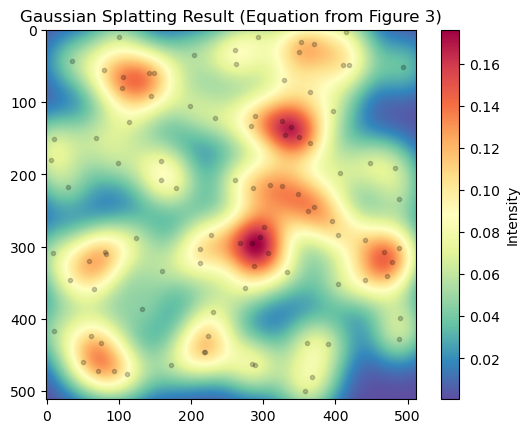

In [55]:
import numpy as np

def gaussian_splatting_equation(points, image_shape, sigmas):
    """
    Perform Gaussian splatting using the equation from Figure 3 of the referenced article.

    Parameters:
    points : numpy.ndarray
        Array of shape (N, 2) representing 2D positions (x, y) of points.
    image_shape : tuple
        Tuple representing the shape (height, width) of the output image.
    sigmas : numpy.ndarray
        Array of shape (N,) representing the standard deviations for each point.

    Returns:
    numpy.ndarray
        An image with the splatted points.
    """
    height, width = image_shape
    image = np.zeros(image_shape)

    # Define a grid of coordinates
    x = np.arange(width)
    y = np.arange(height)
    X, Y = np.meshgrid(x, y, indexing='xy')

    for i, point in enumerate(points):
        # Calculate the Gaussian kernel
        dx = X - point[0]
        dy = Y - point[1]
        d_squared = dx**2 + dy**2
        kernel = (1 / sigmas[i]) * np.exp(-0.5 * d_squared / sigmas[i]**2)

        # Update the image by adding the weighted Gaussian kernel
        image += kernel

    return image

# Example usage:
# Generate random 2D points and sigmas
np.random.seed(0)
num_points = 100
points = np.random.rand(num_points, 2) * 500  # Random points in a 100x100 space
sigmas = np.ones(num_points) * 30 #np.random.randn(num_points) * 100  # Random sigmas

# Define image shape
image_shape = (512, 512)

# Perform Gaussian splatting using the equation
result_image = gaussian_splatting_equation(points, image_shape, sigmas)

# Plot the result
plt.imshow(result_image, cmap='Spectral_r')
plt.plot(points[:, 0], points[:, 1], 'k.', alpha=0.2)  # Overlay the original points
plt.colorbar(label='Intensity')
plt.title('Gaussian Splatting Result (Equation from Figure 3)')
plt.show()


3.11.5 (main, Sep 11 2023, 13:54:46) [GCC 11.2.0]

  TensorMesh: 13,651 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x    187     -2,338.70      2,338.70      5.00    648.73    1.50
   y     73     -2,233.70          2.50      5.00    648.73    1.50




/tmp/ipykernel_4888/2832579691.py:93: FutureWarning: TensorMesh.plotImage has been deprecated, please use TensorMesh.plot_image. It will be removed in version 1.0.0 of discretize.
  mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})
/home/juanito/mambaforge/envs/jresearch/lib/python3.11/site-packages/discretize/utils/code_utils.py:313: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  return getattr(self, new_name)(*args, **kwargs)
/tmp/ipykernel_4888/2832579691.py:118: FutureWarning: ExtractCoreMesh has been deprecated, please use extract_core_mesh. It will be removed in version 0.19.0 of SimPEG.
  actcore,  meshCore = utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
/tmp/ipykernel_4888/2832579691.py:122: FutureWarning: pcolorOpts has been deprecated, please use pcolor_opts
  mm = meshCore.plot_image(
/home/juanito/mambaforge/envs/jresearch/lib/python3.11/site-packages/SimPEG/electromagnetics/static/resistivity/simulation_2d.py:756: RuntimeWarn

0.05003490350209774
5.62537967422244
0.0939381142077316
0.2037967635624132


Text(0.5, 1.0, 'Relative Error ($\\frac{\\sigma^{2}}{d_{obs}}$)')

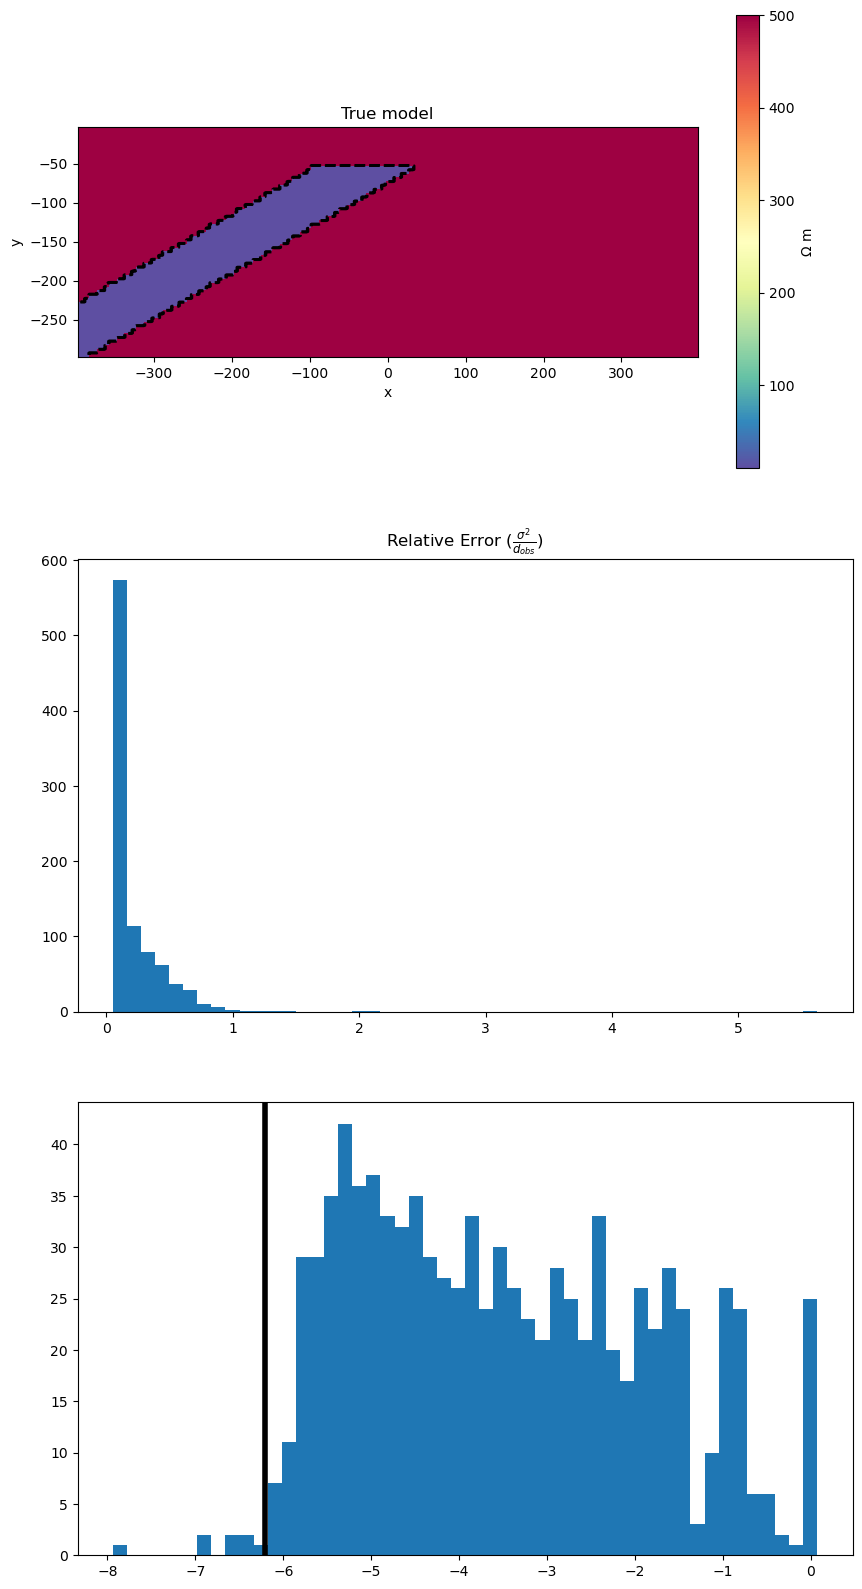

In [56]:
import geological_segmentation as geoseg
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver
from SimPEG.electromagnetics.static import resistivity as dc, utils as dcutils
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from scipy.stats import norm
import scipy.sparse as sp
from sklearn.mixture import GaussianMixture
import copy
# setup the GMMRF
from scipy import spatial, linalg
from segment_anything import sam_model_registry
from segment_anything import SamAutomaticMaskGenerator
from PIL import Image
from scipy import stats
from matplotlib import cm
from scipy.special import logsumexp
from sklearn.mixture._gaussian_mixture import (
    _compute_precision_cholesky,
)
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import datetime
import warnings
import random

# Python Version
import sys
print(sys.version)

# Reproducible science
seed = 12345
np.random.seed(seed)

from pathlib import Path

from SimPEG.regularization import (

    PGIsmallness,
)

from scipy.ndimage import laplace

# -------------------------------------------------------------------------------------------------

# create a 2d mesh for a dc simulation

#

#2D mesh
csx,  csy,  csz = 5.,  5.,  5.
# Number of core cells in each direction
ncx,  ncz = 163,  61
# Number of padding cells to add in each direction
npad = 12
# Vectors of cell lengthts in each direction
hx = [(csx, npad,  -1.5), (csx, ncx), (csx, npad,  1.5)]
hz = [(csz, npad, -1.5), (csz, ncz)]
# Create mesh
mesh = discretize.TensorMesh([hx,  hz], x0="CN")
mesh.x0[1] = mesh.x0[1] + csz / 2.

print(mesh)

# -----------------------------------------------------------------------

# create a synthetic model for a dc simulation

#

model = 3 * np.ones(mesh.nC, dtype='int64')

# divide domain by  45* fault at 100 m
fault_function = lambda x, slope, shift: slope * x + shift

# Dike 30*
dike0 = mesh.gridCC[:,1] > fault_function(
    mesh.gridCC[:,0], np.tan(30 * np.pi / 180), -75)
dike1 = mesh.gridCC[:,1] < fault_function(
    mesh.gridCC[:,0], np.tan(30 * np.pi / 180), 0)
dike = np.logical_and(dike0,dike1)

model[dike]=4

# plot
fig,ax = plt.subplots(3, 1,figsize=(10,20))
mm1 = mesh.plotImage(model, ax=ax[0], pcolorOpts={'cmap':'Spectral_r'})

ax[0].set_xlim([-1000,1000])
ax[0].set_ylim([-250,0])
# ax[0].set_aspect(2)
# plt.colorbar(mm1[0])


# define conductivities
res_true = np.ones(mesh.nC)
res_true[model==3]= 500
res_true[model==4]= 10

index_deep = mesh.gridCC[:, 1] >= -50

res_true[index_deep] = 500

cond_true = 1./res_true

mtrue = np.log(cond_true)

xmin, xmax = -400., 400.
ymin, ymax = -300., 0.
zmin, zmax = 0, 0
xyzlim = np.r_[[[xmin, xmax], [ymin, ymax]]]
actcore,  meshCore = utils.mesh_utils.ExtractCoreMesh(xyzlim, mesh)
actind = np.ones_like(actcore)

# plot
mm = meshCore.plot_image(
    
    1/(cond_true)[actcore],
    ax=ax[0],
    pcolorOpts={'cmap':'Spectral_r'}

)

utils.plot2Ddata(

    meshCore.gridCC,mtrue[actcore],nx=500,ny=500,
    contourOpts={'alpha':0},
    #clim=[0,5],
    ax=ax[0],
    level=True,
    ncontour=2,
    levelOpts={'colors':'k','linewidths':2,'linestyles':'--'},
    method='nearest'
    
)
#plt.gca().set_ylim([-200,0])
ax[0].set_aspect(1)
plt.colorbar(mm[0], label=r'$\Omega$ m')
ax[0].set_title('True model')

xmin, xmax = -350., 350.
ymin, ymax = 0., 0.
zmin, zmax = 0, 0

endl = np.array([[xmin, ymin, zmin], [xmax, ymax, zmax]])
srclist = []

for dipole in np.linspace(25,250,10):
    
    survey1 = dcutils.generate_dcip_survey(
        
        endl, survey_type="pole-dipole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )

    # print(dipole)

    survey2 = dcutils.generate_dcip_survey(
        
        endl, survey_type="dipole-pole",
        dim=mesh.dim,
        a=dipole,
        b=dipole,
        n=16,
    
    )
    
    srclist +=(survey1.source_list)
    srclist +=(survey2.source_list)

survey = dc.Survey(srclist)

# Setup Problem with exponential mapping and Active cells only in the core mesh
expmap = maps.ExpMap(mesh)
mapactive = maps.InjectActiveCells(
    
    mesh=mesh,
    indActive=actcore,
    valInactive=-np.log(100)

)
mapping = expmap * mapactive
simulation = dc.Simulation2DNodal(
    
    mesh, 
    survey=survey, 
    sigmaMap=mapping,
    solver=Solver,
    nky=8

)

# -----------------------------------------------------------------------

# create synthetic data and view psuedo-section

#

relative_measurement_error = 0.05
dc_data = simulation.make_synthetic_data(
    
    mtrue[actcore],
    relative_error=relative_measurement_error,
    noise_floor=5e-4,
    force=True,
    add_noise=True,

)

dc_data.noise_floor = np.quantile(np.abs(dc_data.dobs), 0.008)

relative_error_list = (np.abs(dc_data.standard_deviation/dc_data.dobs))
print(relative_error_list.min())
print(relative_error_list.max())
print(np.median(relative_error_list))
print(relative_error_list.mean())
ax[1].hist(relative_error_list, 50)
ax[2].hist(np.log(np.abs(dc_data.dobs)), 50)
ax[2].axvline(np.log(np.quantile(np.abs(dc_data.dobs), 0.008)), color='k', linewidth=4)
ax[1].set_title(r'Relative Error ($\frac{\sigma^{2}}{d_{obs}}$)')

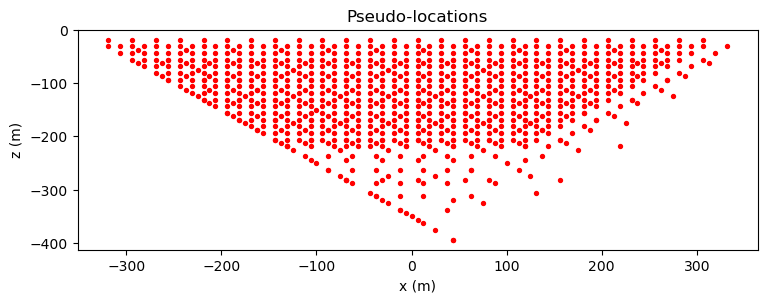

In [58]:
from SimPEG.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    pseudo_locations,
    plot_pseudosection,
    apparent_resistivity_from_voltage,
)

pseudo_locations_xz = pseudo_locations(survey)
fig = plt.figure(figsize=(8, 2.75))
ax = fig.add_axes([0.1, 0.1, 0.85, 0.8])
ax.scatter(pseudo_locations_xz[:, 0], pseudo_locations_xz[:, -1], 8, 'r')
ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')
ax.set_title('Pseudo-locations')
plt.show()

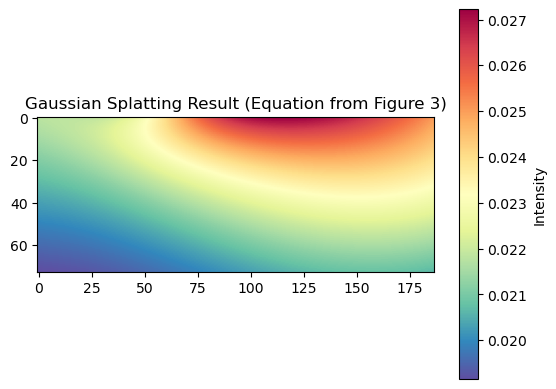

In [80]:
sigmas = np.random.randn(survey.nD) * 10000  # Random sigmas
points = pseudo_locations_xz
# Define image shape
image_shape = (len(mesh.h[1]), len(mesh.h[0]))

# Perform Gaussian splatting using the equation
result_image = gaussian_splatting_equation(points, image_shape, sigmas)

# Plot the result
plt.imshow(result_image, cmap='Spectral_r')
# plt.plot(points[:, 0], points[:, 1], 'k.', alpha=0.2)  # Overlay the original points
plt.colorbar(label='Intensity')
plt.title('Gaussian Splatting Result (Equation from Figure 3)')
plt.show()

In [67]:
survey.nD

920

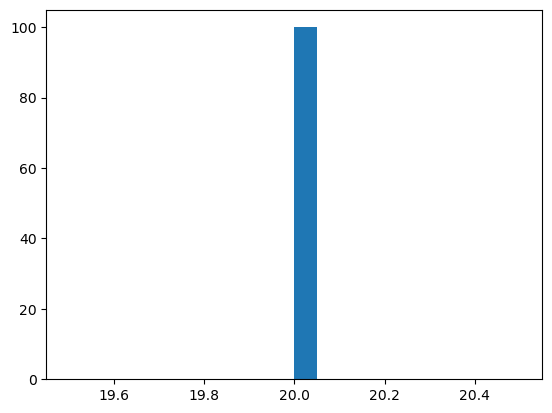

In [46]:
plt.hist(sigmas, bins=20)
plt.show()

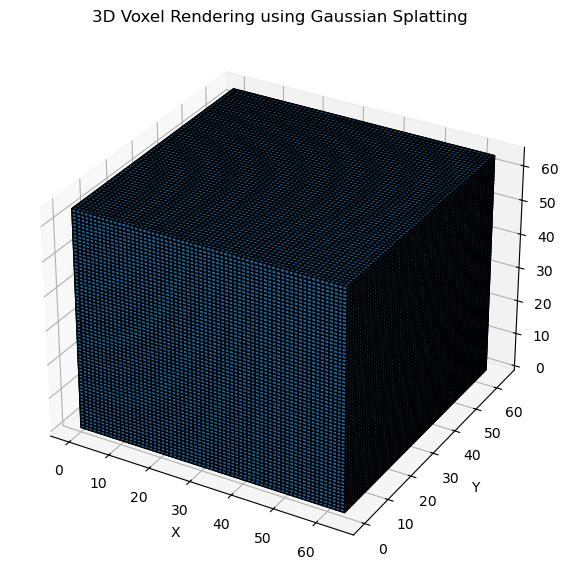

In [51]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def gaussian_splatting_3d(points, intensities, volume_shape, sigma=1.0):
    """
    Perform Gaussian splatting for the given 3D points onto a 3D voxel volume.

    Parameters:
    points : numpy.ndarray
        Array of shape (N, 3) representing 3D points (x, y, z).
    intensities : numpy.ndarray
        Array of shape (N,) representing intensities of the points.
    volume_shape : tuple
        Tuple representing the shape (depth, height, width) of the output voxel volume.
    sigma : float, optional
        Standard deviation of the Gaussian function, controls the spread of splatted points.

    Returns:
    numpy.ndarray
        A 3D voxel volume with the splatted points.
    """
    depth, height, width = volume_shape
    volume = np.zeros(volume_shape)

    # Define a grid of coordinates
    x = np.arange(width)
    y = np.arange(height)
    z = np.arange(depth)
    X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

    for point, intensity in zip(points, intensities):
        # Calculate the Gaussian kernel
        dz = Z - point[2]
        dy = Y - point[1]
        dx = X - point[0]
        d_squared = dx**2 + dy**2 + dz**2
        kernel = intensity * np.exp(-0.5 * d_squared / sigma**2)

        # Update the voxel volume by adding the Gaussian kernel
        volume += kernel

    return volume

# Example usage:
# Generate random 3D points and intensities
np.random.seed(0)
num_points = 1000
points = np.random.rand(num_points, 3) * 100  # Random points in a 100x100x100 space
intensities = np.ones(num_points) * 200 # np.random.rand(num_points)  # Random intensities for the points

# Define voxel volume shape
volume_shape = (64, 64, 64)

# Perform Gaussian splatting for 3D voxel rendering
result_volume = gaussian_splatting_3d(points, intensities, volume_shape, sigma=5.0)

# Plot the 3D voxel volume
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.voxels(result_volume, edgecolor='k')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Voxel Rendering using Gaussian Splatting')
plt.show()


(array([ 2874., 14193., 22438., 26690., 29558., 30513., 29359., 26212.,
        20732., 16368., 13790., 10859.,  7213.,  4817.,  3145.,  1847.,
          888.,   413.,   171.,    64.]),
 array([   6.016553  ,   59.97879251,  113.94103201,  167.90327151,
         221.86551101,  275.82775051,  329.78999002,  383.75222952,
         437.71446902,  491.67670852,  545.63894803,  599.60118753,
         653.56342703,  707.52566653,  761.48790603,  815.45014554,
         869.41238504,  923.37462454,  977.33686404, 1031.29910355,
        1085.26134305]),
 <BarContainer object of 20 artists>)

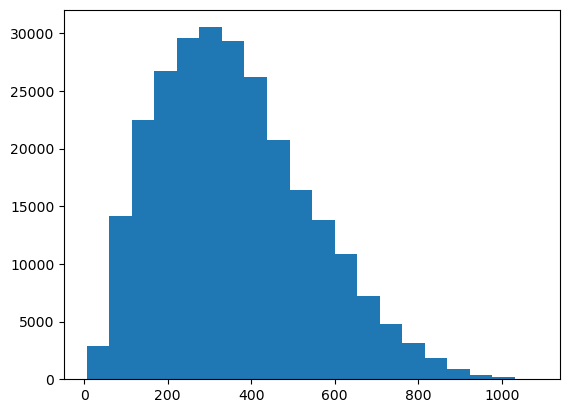

In [53]:
plt.hist(result_volume.flatten(), bins=20)